In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

78876 rows of dihiggs data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met',
       'met_phi', 'scalarHT', 'nJets', 'nBTags', 'isMatchable', 'jet1_pt',
       'jet2_pt', 'jet3_pt', 'jet4_pt', 'jet1_eta', 'jet2_eta', 'jet3_eta',
       'jet4_eta', 'jet1_phi', 'jet2_phi', 'jet3_phi', 'jet4_phi', 'jet1_mass',
       'jet2_mass', 'jet3_mass', 'jet4_mass', 'jet1_px', 'jet2_px', 'jet3_px',
       'jet4_px', 'jet1_py', 'jet2_py', 'jet3_py', 'jet4_py', 'jet1_pz',
       'jet2_pz', 'jet3_pz', 'jet4_pz', 'jet1_energy', 'jet2_energy',
       'jet3_energy', 'jet4_energy', 'jet1_btag', 'jet2_btag', 'jet3_btag',
       'jet4_btag', 'isSignal'],
      dtype='object')
29176 rows of qcd data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'de

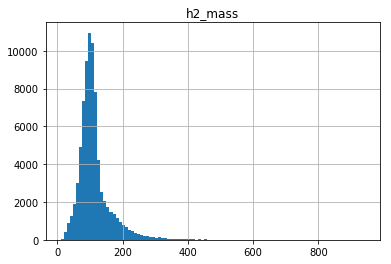

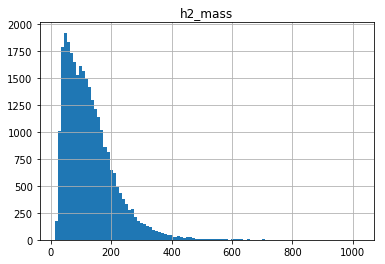

In [2]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')

hh_raw.head()
hh_raw['isSignal'] = 1
print(len(hh_raw), "rows of dihiggs data", hh_raw.columns)
#print( print(hh_raw.loc[[10]]))

qcd_raw.head()
qcd_raw['isSignal'] = 0
print(len(qcd_raw), "rows of qcd data", qcd_raw.columns)

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
#variableNames = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#print(hh_reducedData.columns, variableNames[0])

# *** 1. Make mix of dihiggs and QCD 
hh_reducedData  = hh_raw[variableNames]
qcd_reducedData = qcd_raw[variableNames]
hh_labels  = hh_raw[ ['isSignal'] ]
qcd_labels = qcd_raw[ ['isSignal'] ]

# ** a. Get 20k Events of each 
nEventsToUse = 20000
hh_reducedDataForBDT  = hh_reducedData[:nEventsToUse]
qcd_reducedDataForBDT = qcd_reducedData[:nEventsToUse]
hh_labelsForBDT       = hh_labels[:nEventsToUse]
qcd_labelsForBDT      = qcd_labels[:nEventsToUse]
all_reducedDataForBDT = hh_reducedDataForBDT.append(qcd_reducedDataForBDT)
all_labelsForBDT      = hh_labelsForBDT.append(qcd_labelsForBDT)


# ** B. Use additional 10k for unambiguous testing 
hh_reducedDataForPlots  = hh_reducedData[nEventsToUse:len(qcd_reducedData)]
qcd_reducedDataForPlots = qcd_reducedData[nEventsToUse:len(qcd_reducedData)]
hh_labelsForPlots       = hh_labels[nEventsToUse:len(qcd_reducedData)]
qcd_labelsForPlots      = qcd_labels[nEventsToUse:len(qcd_reducedData)]


hh_reducedData.hist(column=variableNames[2], bins=100)
qcd_reducedData.hist(column=variableNames[2], bins=100)

print(len(all_reducedDataForBDT), 'rows of data with ', len(all_labelsForBDT), 'labels [BDT]')
print(len(hh_reducedDataForPlots), 'rows of dihiggs data with ', len(qcd_labelsForPlots), 'rows of qcd [Plots]')

In [3]:
# ***9. Use equal numbers of signal and background

# ***1. Split dataset into test + train, make correct input objects
data_train, data_test, label_train, label_test = train_test_split(all_reducedDataForBDT, all_labelsForBDT, test_size=0.3)

D_train = xgb.DMatrix(data_train, label=label_train)
D_test = xgb.DMatrix(data_test, label=label_test)

In [4]:
# ***2. Define XGB model and train
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    #'objective': 'reg:logistic',  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 5  # The number of training iterations

model = xgb.train(param, D_train, steps)

In [5]:
# ***3. Evaluate model
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))

Precision = 0.7287897620150101
Recall = 0.7269189674661181
Accuracy = 0.72675


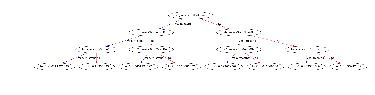

In [11]:
# ***0. Dump .txt of trees and leaves with decisions
#model.dump_model('dumpTree.reduced_bdt.txt')

# Make a visual of decision tree
xgb.plot_tree(model,num_trees=0)
#plt.rcParams['figure.figsize'] = [2000, 400]
#plt.show()
plt.savefig('tree0.png')


([array([   0., 4896.,  355.,  244.,  780.,  977.,  617.,  533.,  640.,
          134.]),
  array([ 134.,  640.,  533.,  617.,  977.,  780.,  244.,  355., 4896.,
            0.])],
 array([0.18532063, 0.2482565 , 0.3111924 , 0.37412825, 0.43706414,
        0.5       , 0.5629359 , 0.6258718 , 0.6888076 , 0.7517435 ,
        0.8146794 ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

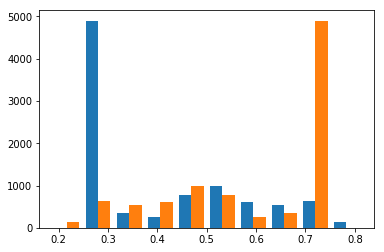

In [7]:
# Make some 1D histograms of decision outputs
hh_DMatrix = xgb.DMatrix(hh_reducedDataForPlots, label=hh_labelsForPlots)
preds_hh = model.predict(hh_DMatrix)
plt.hist(preds_hh)

([array([   0.,  965.,  161.,  160.,  761., 1065., 1074., 1229., 2481.,
         1280.]),
  array([1280., 2481., 1229., 1074., 1065.,  761.,  160.,  161.,  965.,
            0.])],
 array([0.18532063, 0.2482565 , 0.3111924 , 0.37412825, 0.43706414,
        0.5       , 0.5629359 , 0.6258718 , 0.6888076 , 0.7517435 ,
        0.8146794 ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

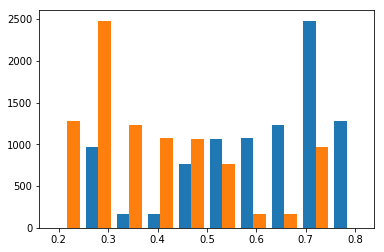

In [9]:
qcd_DMatrix = xgb.DMatrix(qcd_reducedDataForPlots, label=qcd_labelsForPlots)
preds_qcd = model.predict(qcd_DMatrix)
plt.hist(preds_qcd)